In [1]:
import random
import numpy as np
import pandas as pd
from Bio import SeqIO

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

Dataprocessing

In [3]:
def process_fasta_file(file_path, label, full_sequence_data):
    for record in SeqIO.parse(file_path, "fasta"):
        seq = str(record.seq).upper()
        if "N" in seq or len(seq) < 200:
            continue
        full_sequence_data.append((seq, label))

def kmer_format(dataset, k=6):
    all_kmers = []
    for sequence, label in dataset:
        s = sequence.upper()
        kmers = [s[i:i+k] for i in range(len(s) - k + 1)] if len(s) >= k else []
        all_kmers.append((kmers, label))
    return all_kmers

def build_vocab(all_kmers):
    vocab = {}
    next_id = 1  # 0 reserved for padding
    for kmers, _ in all_kmers:
        for k in kmers:
            if k not in vocab:
                vocab[k] = next_id
                next_id += 1
    return vocab

def convert_kmers_to_indices(all_kmers, vocab, max_len=1000):
    out = []
    for kmers, label in all_kmers:
        indices = [vocab.get(k, 0) for k in kmers]
        indices = indices[:max_len] + [0] * max(0, max_len - len(indices))
        out.append((indices, label))
    return out

class IndexedRNADataset(Dataset):
    def __init__(self, indexed_data):
        self.inputs = [torch.tensor(x, dtype=torch.long) for x, _ in indexed_data]
        self.labels = [torch.tensor(y, dtype=torch.float) for _, y in indexed_data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]


In [ ]:
from Bio import SeqIO
import gzip

input_path = r"C:\Users\andyz\Downloads\gencode.v48.pc_transcripts.fa.gz"
output_path = r"C:\Users\andyz\Downloads\extract_mRNA_subset.fa"
N = 50000  #Number of sequences to extract

#Open the gzip-compressed input file in text mode with correct encoding
with gzip.open(input_path, "rt", encoding="utf-8") as input_handle, open(output_path, "w") as output_handle:
    for i, record in enumerate(SeqIO.parse(input_handle, "fasta")):
        if i >= N:
            break
        SeqIO.write(record, output_handle, "fasta")


In [4]:
# Paths to your pre-processed FASTA files
incrna_fasta = r"extract_lncRNA_subset.fa"
mrna_fasta  = r"extract_mRNA_subset.fa"

# Reproducibility
random.seed(1)
torch.manual_seed(1)

# Load sequences
full_sequence_data = []
process_fasta_file(incrna_fasta, 0, full_sequence_data)  # 0 = lncRNA
process_fasta_file(mrna_fasta,  1, full_sequence_data)   # 1 = mRNA
random.shuffle(full_sequence_data)

Model

In [5]:
MAX_LEN   = 1000
EMBED_DIM = 64

class CNNRNAClassifier(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 1, embedding_dim=EMBED_DIM, padding_idx=0)
        self.conv1 = nn.Conv1d(EMBED_DIM, 128, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(256 * (MAX_LEN // 4), 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))


Training

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, device):
    criterion = nn.BCELoss()

    train_acc_epoch = []
    val_acc_epoch = []
    loss_epoch = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = (outputs > 0.5).float()
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)
            running_loss += loss.item() * labels.size(0)

        avg_loss = running_loss / running_total
        loss_epoch.append(avg_loss)

        model.eval()
        with torch.no_grad():
            correct_tr, total_tr = 0, 0
            for x_tr, y_tr in train_loader:
                x_tr, y_tr = x_tr.to(device), y_tr.to(device).unsqueeze(1)
                pred_tr = (model(x_tr) > 0.5).float()
                correct_tr += (pred_tr == y_tr).sum().item()
                total_tr += y_tr.size(0)
        epoch_train_acc = correct_tr / total_tr
        train_acc_epoch.append(epoch_train_acc)

        with torch.no_grad():
            correct_val, total_val = 0, 0
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device).unsqueeze(1)
                pred_val = (model(x_val) > 0.5).float()
                correct_val += (pred_val == y_val).sum().item()
                total_val   += y_val.size(0)
        epoch_val_acc = correct_val / total_val
        val_acc_epoch.append(epoch_val_acc)

        print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} | "f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    import matplotlib.pyplot as plt

    epochs = list(range(1, num_epochs + 1))
    plt.title("Training Loss Curve")
    plt.plot(epochs, loss_epoch, label="Train Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.show()

    plt.title("Training Accuracy Curve")
    plt.plot(epochs, train_acc_epoch, label="Train Acc")
    plt.plot(epochs, val_acc_epoch,   label="Val Acc")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

    print(f"Final Training Accuracy: {train_acc_epoch[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc_epoch[-1]:.4f}")

    return model


In [6]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, device):
    criterion = nn.BCELoss()
    train_acc_epoch = []
    val_acc_epoch = []
    loss_epoch = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = (outputs > 0.5).float()
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)
            running_loss += loss.item() * labels.size(0)
        avg_loss = running_loss / running_total
        loss_epoch.append(avg_loss)

        model.eval()
        with torch.no_grad():
            correct_tr, total_tr = 0, 0
            for x_tr, y_tr in train_loader:
                x_tr, y_tr = x_tr.to(device), y_tr.to(device).unsqueeze(1)
                pred_tr = (model(x_tr) > 0.5).float()
                correct_tr += (pred_tr == y_tr).sum().item()
                total_tr += y_tr.size(0)
        epoch_train_acc = correct_tr / total_tr
        train_acc_epoch.append(epoch_train_acc)

        with torch.no_grad():
            correct_val, total_val = 0, 0
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device).unsqueeze(1)
                pred_val = (model(x_val) > 0.5).float()
                correct_val += (pred_val == y_val).sum().item()
                total_val   += y_val.size(0)
        epoch_val_acc = correct_val / total_val
        val_acc_epoch.append(epoch_val_acc)

        print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")

    import matplotlib.pyplot as plt
    epochs_range = list(range(1, num_epochs + 1))

    plt.figure(figsize=(6,5))
    plt.title("Training Loss Curve")
    plt.plot(epochs_range, loss_epoch, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7,5))
    plt.title("Training Accuracy Curve")
    plt.plot(epochs_range, train_acc_epoch, label="Train Acc")
    plt.plot(epochs_range, val_acc_epoch,   label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print(f"Final Training Accuracy: {train_acc_epoch[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc_epoch[-1]:.4f}")

    return model


Main

CUDA available: True
Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Epoch 01 | Loss: 0.4332 | Train Acc: 0.8909 | Val Acc: 0.8777
Epoch 02 | Loss: 0.2725 | Train Acc: 0.9353 | Val Acc: 0.9070
Epoch 03 | Loss: 0.2077 | Train Acc: 0.9405 | Val Acc: 0.9009
Epoch 04 | Loss: 0.1543 | Train Acc: 0.9646 | Val Acc: 0.9132
Epoch 05 | Loss: 0.1100 | Train Acc: 0.9854 | Val Acc: 0.9214


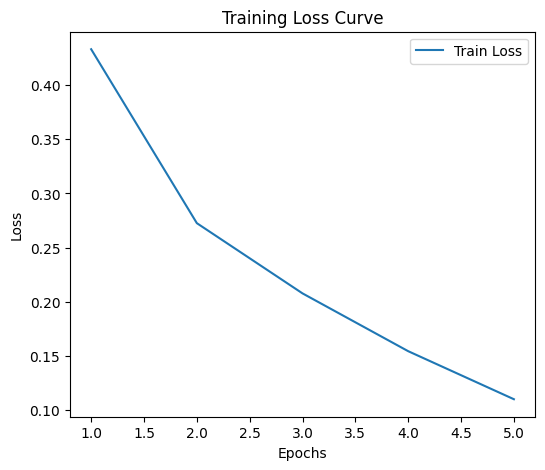

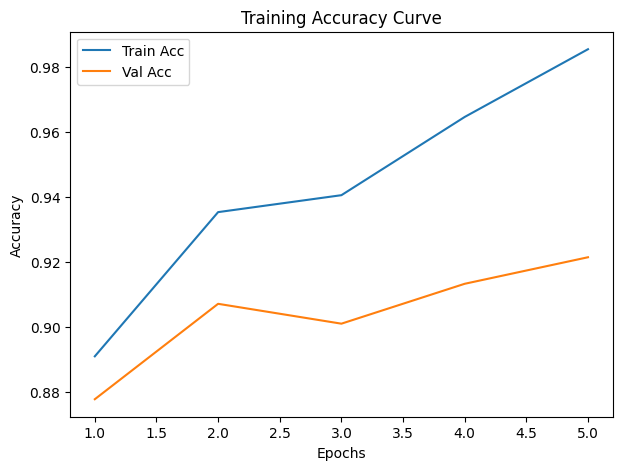

Final Training Accuracy: 0.9854
Final Validation Accuracy: 0.9214


In [11]:
incrna_fasta = r"extract_lncRNA_subset.fa"
mrna_fasta  = r"extract_mRNA_subset.fa"

kmer_k     = 5
max_len    = 1000
batch_size = 32
num_epochs = 5
lr         = 0.001

#K-mer processing
all_kmers    = kmer_format(full_sequence_data, k=kmer_k)
kmer_numbers = build_vocab(all_kmers)
indexed_data = convert_kmers_to_indices(all_kmers, kmer_numbers, max_len=max_len)

#Train/val/test split
N = len(indexed_data)
train_end = int(N * 0.7)
val_end   = train_end + int(N * 0.2)

train_dataset = IndexedRNADataset(indexed_data[:train_end])
val_dataset   = IndexedRNADataset(indexed_data[train_end:val_end])
test_dataset  = IndexedRNADataset(indexed_data[val_end:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNRNAClassifier(vocab_size=len(kmer_numbers)).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model = train_model(model, train_loader, val_loader, optimizer, num_epochs, device)


In [15]:
torch.save(model.state_dict(), "rna_classifier_weights.pth")